# Train Cars 


### Version 3
Use YOLO to find cars and use overlapping boxes heatmaps


### Version 2
Change the loss function to incorporate high recall. F(2).  β(vehicle)=2


### Version 1




In [2]:
import os
import numpy as np

from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import random

from skimage.io import imread_collection

K.set_image_data_format('channels_last')



Using TensorFlow backend.


In [44]:
# Load Images 
data_dir = '../data/'
#data_dir = '../data1/' #No Cars
#data_dir = '../data2/'

images_raw = imread_collection(data_dir +'CameraRGB/*.png')
labels_raw = imread_collection(data_dir +'CameraSeg/*.png')

images_raw = np.array(images_raw)
labels_raw = np.array(labels_raw)

print(images_raw.shape)
print(labels_raw.shape)

(1000, 600, 800, 3)
(1000, 600, 800, 3)


In [45]:
# Preprocess images and labels for training
images = images_raw.astype('float32')
images = images[:,175:495,:,:]
images = (images - 128) / 128

car_labels = labels_raw[:,175:495,:,0]
car_labels = np.where(car_labels == 10 ,1,0).astype('uint8')
car_labels = car_labels.reshape((car_labels.shape[0],car_labels.shape[1],car_labels.shape[2],1))

print(images.shape)
print(car_labels.shape)

(1000, 320, 800, 3)
(1000, 320, 800, 1)


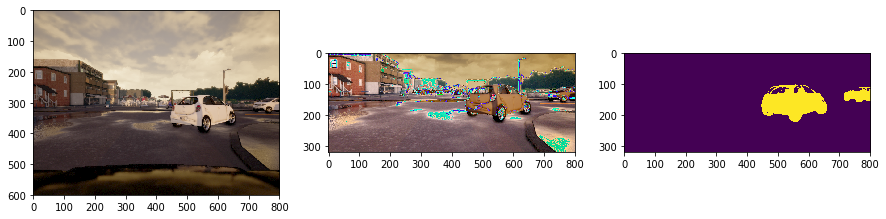

In [46]:
n = 600

fig=plt.figure(figsize=(15, 15))
row = 1
col = 3

fig.add_subplot(row, col, 1)
plt.imshow(images_raw[n]) 

fig.add_subplot(row, col, 2)
plt.imshow(images[n]+1) #plus 1 for moving the mean above '0'

fig.add_subplot(row, col, 3)
plt.imshow(car_labels[n,:,:,0]) #final 0 to show the mask





In [47]:
# Dice Coff used as loss function for detecting road  

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [48]:
# F Score with beta. 
# reference https://en.wikipedia.org/wiki/F1_score
# reference https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient 

smooth = 1. # Add smooth to avoid NaNs 

def F_score_beta(y_true,y_pred,beta):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    TP = K.sum(y_true_f * y_pred_f)
    FP = K.sum(y_pred_f) - TP
    FN = K.sum(y_true_f) - TP
    
    beta_sq = beta*beta
    
    F_score_beta =  ((1. + beta_sq) * TP + smooth) / (((1. + beta_sq) * TP) + beta_sq*FN + FP + smooth) 
    
    return F_score_beta


In [49]:
# Car loss functions
def car_dice_coef(y_true, y_pred):
    return F_score_beta(y_true,y_pred,2)

def car_dice_coef_loss(y_true, y_pred):
    return -car_dice_coef(y_true, y_pred)


In [50]:
# define model 

def get_unet(image_rows,image_cols,loss_function, metric_function):
    inputs = Input((image_rows, image_cols, 3))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), loss=loss_function, metrics=[metric_function])
    #model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
print('-'*30)
print('Loading and preprocessing train data...')
print('-'*30)

print('-'*30)
print('Creating and compiling model...')
print('-'*30)

img_rows = 320
img_cols = 800
car_weights_file = 'carweightsv2_1.h5'


car_model = get_unet(img_rows,img_cols,car_dice_coef_loss,car_dice_coef)
car_model_checkpoint = ModelCheckpoint(car_weights_file, monitor='val_loss', save_best_only=True)

print('-'*30)
print('Fitting model...')
print('-'*30)
#car_model.load_weights(car_weights_file)
history = car_model.fit(images, car_labels, batch_size=2, epochs=10, verbose=1, shuffle=True,
          validation_split=0.2,
          callbacks=[car_model_checkpoint])



------------------------------
Loading and preprocessing train data...
------------------------------
------------------------------
Creating and compiling model...
------------------------------
------------------------------
Fitting model...
------------------------------
Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 137s 171ms/step - loss: -0.1206 - car_dice_coef: 0.1206 - val_loss: -0.0777 - val_car_dice_coef: 0.0777
Epoch 2/10
800/800 [==============================] - 134s 168ms/step - loss: -0.2564 - car_dice_coef: 0.2564 - val_loss: -0.1446 - val_car_dice_coef: 0.1446
Epoch 3/10
800/800 [==============================] - 134s 168ms/step - loss: -0.5074 - car_dice_coef: 0.5074 - val_loss: -0.2137 - val_car_dice_coef: 0.2137
Epoch 4/10
800/800 [==============================] - 134s 168ms/step - loss: -0.5809 - car_dice_coef: 0.5809 - val_loss: -0.2512 - val_car_dice_coef: 0.2512
Epoch 5/10
800/800 [===========================

dict_keys(['val_loss', 'val_car_dice_coef', 'loss', 'car_dice_coef'])


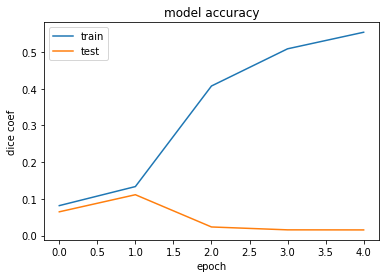

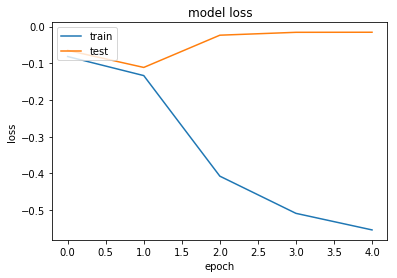

In [33]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['car_dice_coef'])
plt.plot(history.history['val_car_dice_coef'])
plt.title('model accuracy')
plt.ylabel('dice coef')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

------------------------------
Loading saved weights...
------------------------------
------------------------------
Predicting masks on test data...
------------------------------
1/1 [==============================] - 0s 54ms/step


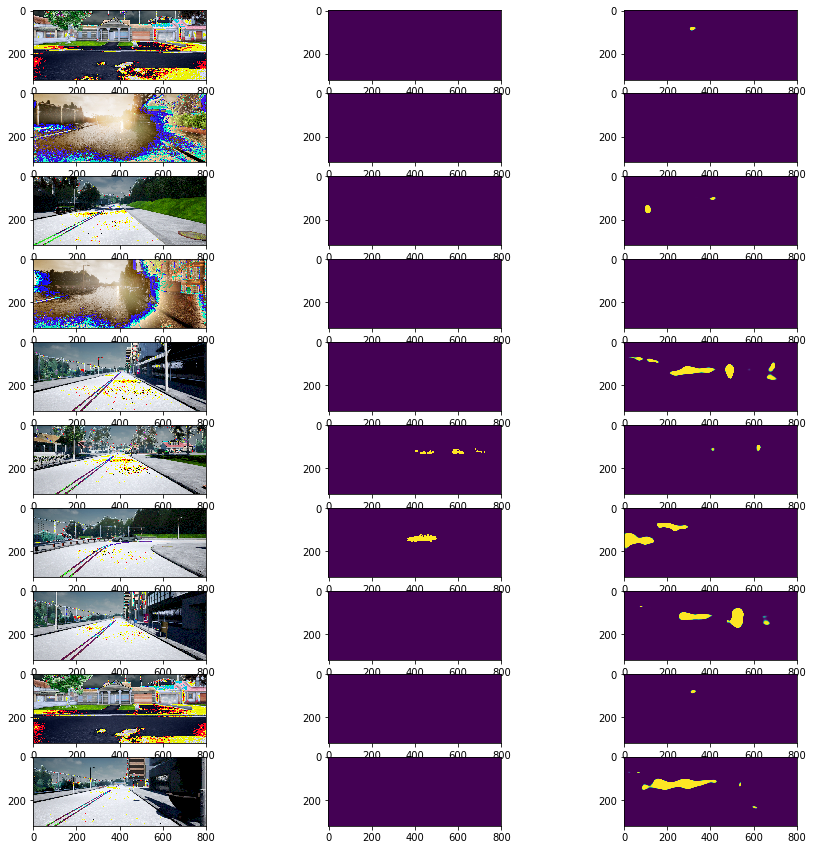

In [43]:
print('-'*30)
print('Loading saved weights...')
print('-'*30)
img_rows = 320
img_cols = 800
car_weights_file = 'carweightsv2.h5'


car_model = get_unet(img_rows,img_cols,car_dice_coef_loss,car_dice_coef)
car_model.load_weights(car_weights_file)

print('-'*30)
print('Predicting masks on test data...')
print('-'*30)

arr = random.sample(range(1000), 10)

fig=plt.figure(figsize=(15, 15))
row = 10
col = 3

for i in range(len(arr)):
    n = arr[i]
    car_pred = car_model.predict(images[n:n+1,:,:,:], verbose=1)

    #fig.add_subplot(row, col, i*3+1)
    #plt.imshow(images_raw[n]) 

    fig.add_subplot(row, col, i*3+1)
    plt.imshow(images[n]+1) #plus 1 for moving the mean above '0'

    fig.add_subplot(row, col, i*3+2)
    plt.imshow(car_labels[n,:,:,0]) #final 0 to show the mask

    fig.add_subplot(row, col, i*3+3)
    plt.imshow(car_pred[0,:,:,0]) #final 0 to show the mask


In [28]:
car_images = images[600:605,:,:,:]
print(car_images.shape)


car_model = get_unet()
car_model.load_weights('carweights.h5')


car_preds = car_model.predict(car_images, verbose=1)
print(car_preds.shape)

fig=plt.figure(figsize=(20, 20))
row = 10
col = 2

for i in range(len(car_images)) :
    fig.add_subplot(row, col, i*2+1)
    plt.imshow(car_images[i]+1) #final 0 to show the mask

    fig.add_subplot(row, col, i*2+2)
    plt.imshow(car_preds[i,:,:,0]) #final 0 to show the maskcar_imagei

(5, 320, 800, 3)


TypeError: get_unet() missing 4 required positional arguments: 'image_rows', 'image_cols', 'loss_function', and 'metric_function'

In [2]:
import io
import base64
import imageio
imageio.plugins.ffmpeg.download()


Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.03194880/45929032 bytes (7.0%7004160/45929032 bytes (15.210608640/45929032 bytes (23.1%14368768/45929032 bytes (31.3%18145280/45929032 bytes (39.5%21929984/45929032 bytes (47.7%25772032/45929032 bytes (56.1%29564928/45929032 bytes (64.4%33406976/45929032 bytes (72.7%37240832/45929032 bytes (81.1%41050112/45929032 bytes (89.4%44818432/45929032 bytes (97.6%45929032/45929032 bytes (100.0%)
  Done
File saved as /home/paperspace/.imageio/ffmpeg/ffmpeg-linux64-v3.3.1.
